<a href="https://colab.research.google.com/github/lowbee2019/Algorithm/blob/master/MyModel_CNN-V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install emnist

In [53]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets,layers,models
import collections
import copy
import random
import emnist
import datetime

# Server Initialization

In [135]:
class ParamServer(object):
  def __init__(self,init_model_path):
    self.init_model_path = init_model_path
    self.round = 0
    self.optimizer = 'adam'
    self.loss = "sparse_categorical_crossentropy"
    self.metrics =['accuracy']
    self.loss_acc = []

  def PreTrain(self,model,data,labels,batch_size=32,epochs=5):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    _metrics = model.fit(data,labels,batch_size,epochs)
    return model
  
  def PreEval(self,model,validation_data):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    self.loss_acc.append(model.evaluate(x=validation_data[0],y=validation_data[1]))


## Emnist数据集的预处理

In [55]:
LetterDataSet = emnist.extract_training_samples('letters')
DigitDataSet = emnist.extract_training_samples('digits')

LetterDataSet = (np.expand_dims(LetterDataSet[0]/255.0,axis=3),np.expand_dims(LetterDataSet[1]*0+10,axis=1)) 
DigitDataSet = (np.expand_dims(DigitDataSet[0]/255.0,axis=3),np.expand_dims(DigitDataSet[1],axis=1))

In [56]:
LetterDataSet[0].shape,DigitDataSet[0].shape

((124800, 28, 28, 1), (240000, 28, 28, 1))

In [58]:
ShareData = DigitDataSet[0][0:200]
ShareLabel = DigitDataSet[1][0:200]
validation_data=(ShareData,ShareLabel)

## 模型的定义

In [57]:
class FLModel(tf.keras.Model):
  def __init__(self,row,col,num_classes=62,*args,**kwargs):
    super(FLModel,self).__init__(*args,**kwargs)
    self.row = row
    self.col = col
    self.num_classes = num_classes
    # self.flatten = tf.keras.layers.Flatten(input_shape=(row,col))
    # self.dense_1 = tf.keras.layers.Dense(128,activation='relu',name="dense_1")
    # self.dense_2 = tf.keras.layers.Dense(num_classes,activation='softmax',name="dense_2")
    # self.drop = tf.keras.layers.Dropout(0.2)
    
    self.model = models.Sequential()
    # 第1层卷积，卷积核大小为3*3，32个，28*28为待训练图片的大小
    self.model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(self.row, self.col, 1)))
    self.model.add(layers.MaxPooling2D((2, 2)))
    # 第2层卷积，卷积核大小为3*3，64个
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    self.model.add(layers.MaxPooling2D((2, 2)))
    # 第3层卷积，卷积核大小为3*3，64个
    self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    self.model.add(layers.Flatten())
    self.model.add(layers.Dense(64, activation='relu'))
    self.model.add(layers.Dense(num_classes, activation='softmax'))

    # self.model.summary()

    # self.model = model


  
  # def call(self,inputs):
  #   x = self.flatten(inputs)
  #   x = self.dense_1(x)
  #   x = self.drop(x)
  #   x = self.dense_2(x)
  #   return x
  def call(self,inputs):
    return self.model(inputs)

  def copy(self):
    NewModel = FLModel(self.row,self.col,self.num_classes)
    _ = NewModel(tf.convert_to_tensor(np.zeros([1,self.row,self.col,1])))
    ##Layers
    NewVars = NewModel.trainable_variables #此处为空列表，因为没有训练,这个地方参数传递是不是有问题
    OldVars = self.trainable_variables
    for n,o in zip(NewVars,OldVars):
      n.assign(o.numpy())
    return NewModel

  # def compute_output_shape(self,input_shape):
  #   shape = tf.TensorShape(input_shape).as_list()
  #   shape[-1] = self.num_classes
  #   return tf.TensorShape(shape)

#Client Initialization
模型训练和评估都要重写

In [59]:
class Client(object):
  def __init__(self,id,model=None,Train_dataset=None,Test_dataset=None):
    self.id = id
    self.model = model
    self.Train_dataset = Train_dataset
    self.Test_dataset = Test_dataset
    # from ParamServer
    self.ParamModel = None
    self.num_epochs = 5
    self.batch_size = 32
    self.shuffle_buffer = 100
    self.prefetch_buffer = 10


  def ReceiveModel(self,ParamModel,num_epochs=1,batch_size=32,shuffle_buffer=100,prefetch_buffer=10):
    self.ParamModel = ParamModel
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.shuffle_buffer = shuffle_buffer
    self.prefetch_buffer = prefetch_buffer
  

  # def preprocess(self,dataset):
  #   def batch_format_fn(element):
  #     return collections.OrderedDict(
            
  #           x = tf.reshape(element['pixels'],[-1,784]),
  #           y = tf.reshape(element['label'],[-1,1])
  #         )
  #   return dataset.repeat(self.num_epochs).shuffle(self.shuffle_buffer).batch(
  #       self.batch_size).map(batch_format_fn).prefetch(self.prefetch_buffer)

  def NodeTrain(self):
    model = self.ParamModel
    # pre_data = self.preprocess(self.Train_dataset)
    # print(type(pre_data))
    # model.fit(x=pre_data['x'],y=pre_data['y'],batch_size=self.batch_size,epochs=self.num_epochs)
    # x = np.array([i['pixels'].numpy() for i in self.Train_dataset])
    # y = np.array([i['label'].numpy() for i in self.Train_dataset])
    x,y = self.Train_dataset
    model.compile(
        # optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),##'adam',
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    # log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    _metrics = model.fit(x,y,batch_size=self.batch_size,epochs=self.num_epochs)
    self.model = model

  def NodeEval(self):
    x,y = self.Test_dataset
    self.model.evaluate(x,y)


# 阶段一：为Client分配数据（预处理工作）

#阶段一：服务器完成模型初始化

In [51]:
def create_data_for_clients(SampleNum,LetterDataSet,DigitDataSet,DigitPercentage=0.7):
  DigitNum = int(SampleNum*DigitPercentage)
  LetterNum = SampleNum - DigitNum
  x_sequence = []
  y_sequence = []
  if DigitNum > 0:
    for i in range(DigitNum):
      index = random.randint(0,len(DigitDataSet[0])-1)
      x_sequence.append(DigitDataSet[0][index])
      y_sequence.append(DigitDataSet[1][index])
  if LetterNum > 0:
    for j in range(LetterNum):
      index = random.randint(0,len(LetterDataSet[0])-1)
      x_sequence.append(LetterDataSet[0][index])
      y_sequence.append(LetterDataSet[1][index])
  # print(x_sequence[1].shape,y_sequence[1].shape)
  x = np.array(x_sequence,dtype=np.float64)
  y = np.array(y_sequence,dtype=np.int8)
  #shuffle
  state = np.random.get_state()
  np.random.shuffle(x)
  np.random.set_state(state)
  np.random.shuffle(y)
  
  return (x,y)

In [14]:
NUM_CLIENTS = 10
NUM_TRAIN_SAMPLE_CLIENT = 1280
NUM_TEST_SAMPLE_CLIENT = 256

In [123]:
clients=[]
for i in range(NUM_CLIENTS):
  clients.append(Client(i,
                        Train_dataset=create_data_for_clients(SampleNum=NUM_TRAIN_SAMPLE_CLIENT,
                                                              LetterDataSet=LetterDataSet,
                                                              DigitDataSet=DigitDataSet,
                                                              DigitPercentage=random.random()),
                        Test_dataset=create_data_for_clients(SampleNum=NUM_TEST_SAMPLE_CLIENT,
                                                             LetterDataSet=LetterDataSet,
                                                             DigitDataSet=DigitDataSet,
                                                             DigitPercentage=0.7)
                        )
  )

Show DataSet

In [17]:
import matplotlib.pyplot as plt

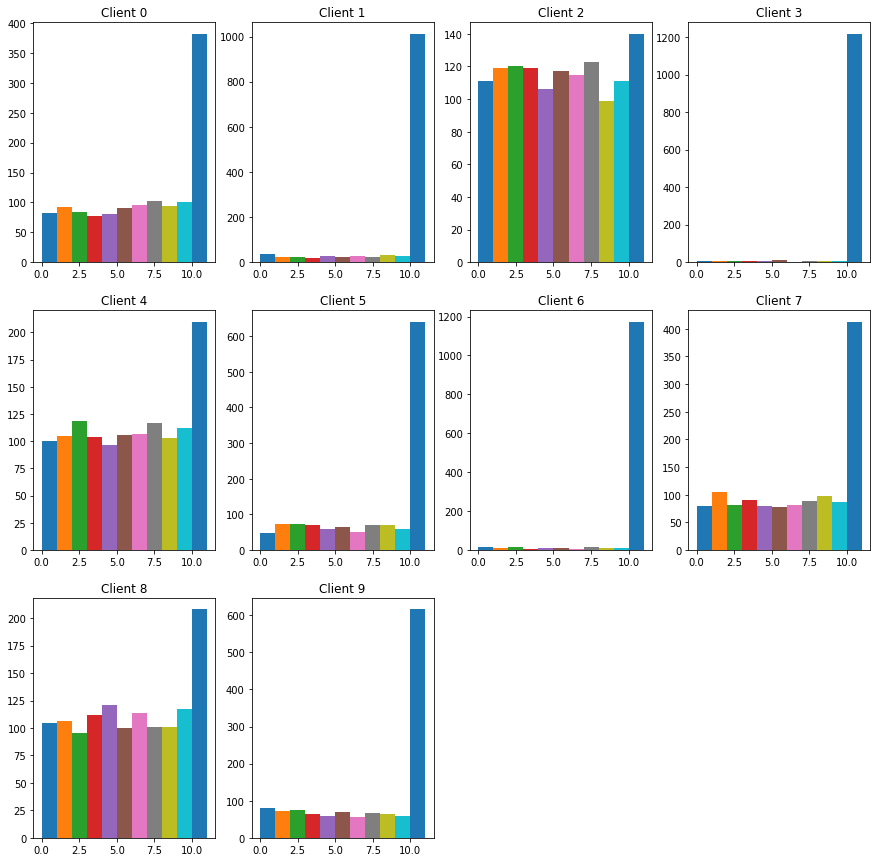

In [125]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = collections.defaultdict(list)
  for [label] in client_dataset[1].tolist():
    plot_data[label].append(label)
  plt.subplot(3,4,i+1)
  plt.title('Client {}'.format(i))
  for j in range(len(plot_data)):
    plt.hist(
        plot_data[j],
        density = False,
        bins = [x for x in range(len(plot_data)+1)]
    )

显示一下数字与字母的对比


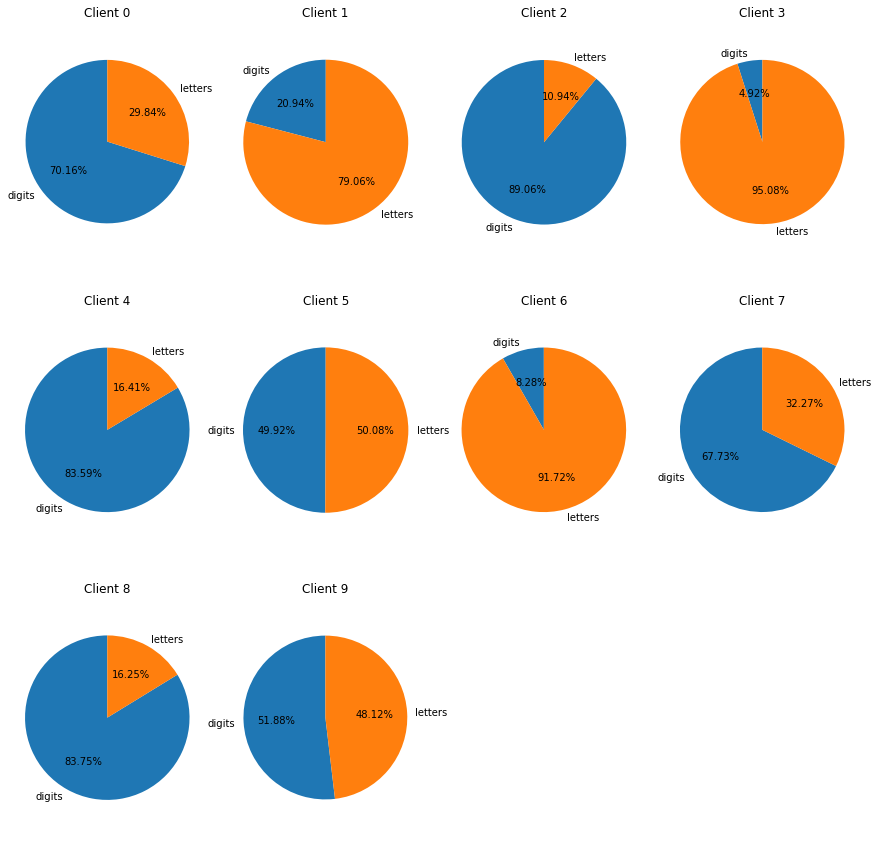

In [124]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = {0:0,1:0}
  plot_labels = ['digits','letters']
  for label in client_dataset[1]:
    label = 0 if label < 10 else 1
    plot_data[label]+=1
  # print(plot_data)
  data_labels = list(sorted(plot_data.keys()))
  # print(data_labels)
  data_nums = [plot_data[i] for i in data_labels]
  colors = ['red','blue']
  plt.subplot(3,4,i+1)
  patches,text1,text2 = plt.pie(data_nums,
                              labels=plot_labels,
                              autopct='%3.2f%%',
                              shadow=False,
                              startangle=90,
                              pctdistance=0.6)
  plt.axis('equal')
  plt.title('Client {}'.format(i))
plt.show()


##阶段二：中央服务器下发模型

Distance Between two models

In [106]:
def Distance(HookModel,TestModel):
  len_it = len(HookModel.trainable_variables)
  Hook_weights=[]
  Test_weights=[]
  for index in range(len_it):
    Hook_weights.append(HookModel.trainable_variables[index].numpy().reshape(-1,))
    Test_weights.append(TestModel.trainable_variables[index].numpy().reshape(-1,))
  target = []
  dis_norm2=[]
  for i in range(len_it):
    target.append(Hook_weights[i]-Test_weights[i])
    dis_norm2.append(np.linalg.norm(target[i],2))
  weight_weights = np.ones([len_it,1])
  #调整权重
  # weight_weights[0]=0
  # weight_weights[1]=0
  dis = np.dot(dis_norm2,weight_weights)
  return dis
  # return dis_norm2

In [107]:
def BetterNode(clients,model,Total_NUM,FedAvg_NUM):
  NodeDict=collections.OrderedDict()
  for i in range(Total_NUM):
    NodeDict[i] = Distance(model,clients[i].model)
  Dlst = sorted(NodeDict.items(),key=lambda x:x[1])
  NodeList = []
  for i in range(FedAvg_NUM):
    NodeList.append(Dlst[i][0])
  return NodeList

模型初始化

In [170]:
InitModel = FLModel(row=28,col=28,num_classes=11)
S = ParamServer("")
S.PreEval(InitModel,validation_data)

7/7 [==============================] - 0s 8ms/step - loss: 2.4100 - accuracy: 0.1173


In [171]:
SendModel = InitModel

In [151]:
SendModel = S.PreTrain(InitModel,ShareData,ShareLabel,epochs=1)
S.PreEval(SendModel,validation_data)

7/7 [==============================] - 0s 8ms/step - loss: 2.1724 - accuracy: 0.3161


# 阶段三：Clients 训练节点数据并聚合


In [152]:
def FedAvg(NUM_CLIENTS,model,FedAvg_NUM=7):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  FedNodeList=BetterNode(clients,iterModel,NUM_CLIENTS,FedAvg_NUM)
  print("FedAvg Node is",FedNodeList)

  # for c in range(Cut):
  #   # tmp =np.array(iterModel.trainable_variables[c].numpy(),dtype='float64')
  #   all_weights.append(iterModel.trainable_variables[c].numpy())

  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in FedNodeList:
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/FedAvg_NUM)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return (iterModel,FedNodeList)

In [153]:
NUM_EPOCHS = 30

In [172]:
NodeList=[]
participator = NUM_CLIENTS
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  if participator < int(0.6*NUM_CLIENTS):
    participator = int(0.6*NUM_CLIENTS) 
  FedModel,li = FedAvg(NUM_CLIENTS,SendModel,FedAvg_NUM=participator)
  participator = participator-1
  NodeList.append(li)
  S.PreEval(FedModel,validation_data)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
40/40 [==============================] - 2s 28ms/step - loss: 2.0603 - accuracy: 0.4243
FedAvg Node is [1, 6, 3, 5, 9, 7, 0, 4, 8, 2]
7/7 [==============================] - 0s 10ms/step - loss: 3.5404 - accuracy: 0.0000e+00
EPOCHS 1 is starting...
40/40 [==============================] - 2s 28ms/step - loss: 1.5531 - accuracy: 0.5292
FedAvg Node is [3, 6, 1, 5, 9, 7, 0, 8, 4]
7/7 [==============================] - 0s 8ms/step - loss: 1.9692 - accuracy: 0.2237
EPOCHS 2 is starting...
40/40 [==============================] - 2s 28ms/step - loss: 0.9351 - accuracy: 0.6598
FedAvg Node is [6, 3, 1, 5, 9, 7, 0, 8]
7/7 [==============================] - 0s 10ms/step - loss: 1.2530 - accuracy: 0.5191
EPOCHS 3 is starting...
40/40 [==============================] - 2s 29ms/step - loss: 0.7556 - accuracy: 0.7154
FedAvg Node is [3, 6, 1, 9, 5, 0, 4]
7/7 [==============================] - 0s 8ms/step - loss: 1.1013 - accuracy: 0.5604
EPOCHS 4 is starting...
40/40 [=========

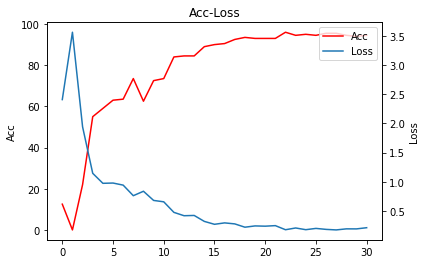

In [173]:
#deal the data
S_acc =[S.loss_acc[i][1]*100 for i in range(len(S.loss_acc))]
S_loss =[S.loss_acc[i][0] for i in range(len(S.loss_acc))]

#prepare show image
x = np.arange(len(S.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_title('Acc-Loss')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss,label='Loss')
ax2.set_ylabel('Loss')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

In [174]:
NodeList

[[1, 6, 3, 5, 9, 7, 0, 4, 8, 2],
 [3, 6, 1, 5, 9, 7, 0, 8, 4],
 [6, 3, 1, 5, 9, 7, 0, 8],
 [3, 6, 1, 9, 5, 0, 4],
 [1, 6, 3, 9, 5, 7],
 [6, 3, 1, 5, 9, 7],
 [1, 6, 9, 5, 0, 3],
 [1, 6, 3, 7, 9, 5],
 [6, 1, 9, 3, 5, 7],
 [1, 5, 6, 3, 9, 7],
 [1, 6, 9, 5, 7, 0],
 [7, 9, 1, 6, 5, 8],
 [5, 6, 9, 1, 0, 7],
 [1, 9, 0, 7, 5, 8],
 [7, 9, 0, 1, 8, 5],
 [1, 9, 5, 0, 7, 8],
 [7, 0, 1, 9, 5, 8],
 [9, 0, 1, 5, 7, 2],
 [7, 0, 9, 8, 1, 5],
 [9, 0, 5, 7, 8, 1],
 [7, 1, 5, 0, 9, 8],
 [0, 5, 7, 9, 1, 8],
 [0, 5, 7, 9, 1, 8],
 [0, 8, 9, 5, 1, 7],
 [9, 7, 5, 1, 0, 8],
 [7, 0, 9, 5, 8, 1],
 [7, 9, 8, 1, 0, 5],
 [9, 0, 5, 7, 1, 8],
 [5, 7, 8, 9, 0, 1],
 [9, 8, 7, 0, 5, 1]]

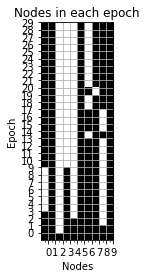

In [157]:
#deal the data
img = np.ones(shape=(NUM_EPOCHS,NUM_CLIENTS),dtype=int)
for i in range(len(NodeList)):
  for j in NodeList[i]:
    img[i][j]=0
#prepare show image
len_n = len(S.loss_acc)
ax = plt.gca()
ax.set_xlim(-0.5,NUM_CLIENTS-0.5)
ax.set_ylim(-0.5,9.5)
miloc = plt.MultipleLocator(1)
ax.xaxis.set_minor_locator(miloc)
plt.grid()
plt.title("Nodes in each epoch")
plt.imshow(img*255,cmap='gray')
plt.axis('on')
plt.xlabel('Nodes')
plt.ylabel('Epoch')
x = np.arange(0.5,NUM_CLIENTS+0.5,1)
y = np.arange(0.5,NUM_EPOCHS+0.5,1)
plt.xticks()
plt.yticks(y,(int(i-0.5) for i in y))
plt.xticks(x,(int(i-0.5) for i in x))
plt.show()

设置对照组，即普通的FedAvg

In [175]:
def FedAvg_Baseline(NUM_CLIENTS,model):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')
    for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/NUM_CLIENTS)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [176]:
InitModel = FLModel(row=28,col=28,num_classes=11)
S2 = ParamServer("")
S2.PreEval(InitModel,validation_data)
SendModel = InitModel

7/7 [==============================] - 0s 8ms/step - loss: 2.3913 - accuracy: 0.1459


In [160]:
SendModel = S2.PreTrain(InitModel,DigitDataSet[0][0:200],DigitDataSet[1][0:200],epochs=1)
S2.PreEval(SendModel,validation_data)

7/7 [==============================] - 0s 8ms/step - loss: 2.2193 - accuracy: 0.2868


In [161]:
NUM_EPOCHS = 30

In [178]:
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  FedModel = FedAvg_Baseline(NUM_CLIENTS,SendModel)
  S2.PreEval(FedModel,validation_data)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
15/40 [==========>...................] - ETA: 0s - loss: 0.2313 - accuracy: 0.9000

KeyboardInterrupt: ignored

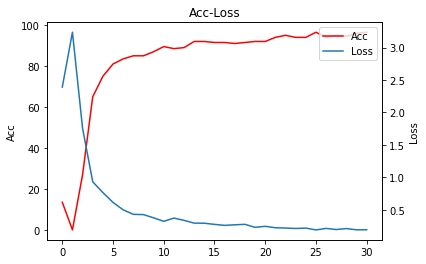

In [179]:
S_acc2 =[S2.loss_acc[i][1]*100 for i in range(len(S2.loss_acc))]
S_loss2 =[S2.loss_acc[i][0] for i in range(len(S2.loss_acc))]

x = np.arange(len(S2.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc2,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_title('Acc-Loss')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss2,label='Loss')
ax2.set_ylabel('Loss')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

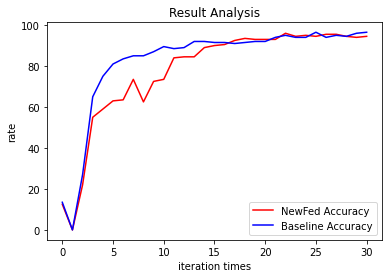

In [180]:
iters = np.arange(len(S2.loss_acc))
fig = plt.figure()
plt.title('Result Analysis')
plt.plot(iters,S_acc,color='red',label='NewFed Accuracy')
plt.plot(iters,S_acc2,color='blue',label='Baseline Accuracy')
plt.legend()
plt.xlabel('iteration times')
plt.ylabel('rate')
plt.show()

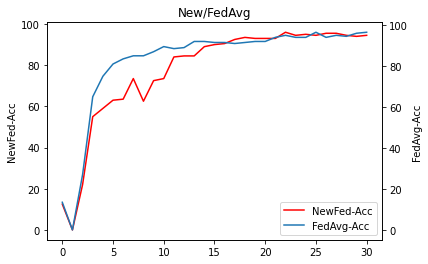

In [181]:
x = np.arange(len(S2.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc,'r',label='NewFed-Acc')
ax1.set_ylabel('NewFed-Acc')
ax1.set_title('New/FedAvg')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_acc2,label='FedAvg-Acc')
ax2.set_ylabel('FedAvg-Acc')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

## 模型聚合 FedAvg
THIS IS THE MOST IMPORANT！

In [ ]:
##先实现普通聚合，再考虑距离问题

In [ ]:
# clients[0].Train_dataset[0].shape

(60000, 28, 28)

In [ ]:
# a_1 = a.trainable_variables
# b_1 = clients[0].model.trainable_variables
# for _a,_b in zip(a_1,b_1):
#   # print(_a,_b,'\n')
#   print(type(_a))

<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>
<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>
<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>
<class 'tensorflow.python.eager.def_function.UnliftedInitializerVariable'>


In [ ]:
# tmp = a_1[0]
# tmp2 = b_1[0]

In [ ]:
# print(tmp.name)
# print(tmp2.name)

fl_model_57/dense_1/kernel:0
fl_model_60/dense_1/kernel:0


In [ ]:
# tmp.numpy()

array([[-0.07970653,  0.07991762,  0.05910995, ...,  0.0579403 ,
         0.0321511 ,  0.02421231],
       [-0.05695383,  0.03625515, -0.06860252, ...,  0.02591816,
         0.04554088,  0.02055327],
       [-0.01783558, -0.04462572, -0.02057564, ...,  0.02187481,
        -0.04054561, -0.02853347],
       ...,
       [-0.05783828, -0.05880497,  0.07976013, ..., -0.03510847,
        -0.03695404,  0.03616227],
       [-0.06651882,  0.02818294, -0.02726433, ..., -0.05769905,
        -0.04426115, -0.00901749],
       [-0.01624558,  0.05673347, -0.07569796, ..., -0.05263541,
        -0.0753431 , -0.04903179]], dtype=float32)

In [ ]:
# tmp.numpy().shape

(784, 128)

In [ ]:
#  tmp2 =np.zeros(a.trainable_variables[0].numpy().shape,dtype='float64')

In [ ]:
# tmp2.shape

(784, 128)

In [ ]:
#聚合先不考虑权重
def FedAvg(NUM_CLIENTS):
  iterModel = a.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [ ]:
fedmodel = FedAvg(10)

In [ ]:
#昨天留的任务是如何把聚合后的numpy数组，转到模型中

In [ ]:
S.PreEval(fedmodel,x_test,y_test)

313/313 [==============================] - 1s 1ms/step - loss: 7.8235 - accuracy: 0.2031


In [ ]:
len(fed)

4